In [58]:
import numpy as np
import pandas as pd
import sklearn.metrics as sk
import scipy 
import igraph
import ts2vg # Time series to visibility graphs
import scipy.spatial.distance as distance
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LinearRegression
import os 
from scipy.stats import t 

#### Tasks para Mutual Information:
    1. Gerar redes contendo o mesmo número de arestas da rede Pearson
    2. Gerar redes com limiar baseado no maior diâmetro (e backbone associado)
    3. Gerar redes com limiar baseado nas maiores (1%) correlações (e backbone associado)
    4. Verificar as características de todas as redes e realizar a geração do shapefile

#### Funções e Classes

In [86]:
class threshold():
    # Remover arestas com peso abaixo de um dado threshold (valor real)
    # entrada: g, flow_threshold
    # retorno: g              
    def remove_edges(g, flow_threshold):
        del_edges = []
        for e in g.es():
            if e['weight'] < flow_threshold:
                del_edges.append(e)
        g.delete_edges(del_edges)
        return g

    # Função que varia o threshold e chama a função acima 
    # remover as arestas abaixo do threshold e em seguida verifica o diâmetro
    # Entrada: g
    # Retorno: threshold (valor real) associado ao maior diâmetro da rede
    def max_diameter_threshold(g):
        max_threshold = max(g.es['weight'])
        max_diameter = 0
        for t in np.arange(0.1, max_threshold, 0.01):
            #print(threshold)
            ng = g.copy()
            ng = threshold.remove_edges(ng, t)
            #print(ng)
            diameter = ng.diameter(directed=False)
            #print(diameter)
            if diameter > max_diameter:
                max_diameter = diameter
                threshold_max_diameter = t
        return threshold_max_diameter

def geographical_distance(adj,pos):
    """
    Parameters:
    -----------
        adj - pares de pontos que correspondem a um ponto (série temporal) disposta no espaço geográfico da 
        bacia do rio Tamanduateí.
        pos - índice (d,j) de cada ponto na matriz que representa o espaço geográfico.
        
    Returns:
    --------
        A distância euclidiana entre os pontos distribuídos na região analisada.
    """
    geo_dist = {}
    for i in adj: # i é o par formado pelos grafos 'a' e 'b'
        a = pos[i[0]] # busca as coordenadas (i,j) do grafo 'a' no vetor que guarda a posição das séries na matriz
        b = pos[i[1]] # busca as coordenadas (i,j) do grafo 'b' no vetor que guarda a posição das séries na matriz
        dist = np.sqrt((a[0]-b[0])**2+(a[1]-b[1])**2)
        geo_dist[i] = dist
    return(geo_dist)

class reading():
    
    def files_and_validation():
        """
        Returns:
        --------
            Realiza a leitura dos arquivos contendo as matrizes de dados. Os dados inválidos das matrizes (-99) são
            removidos, gerando vetores com apenas os valores válidos.
            data ==> Vetor contendo apenas os valores válidos das matrizes
            pos ==> Vetor contendo a posição que os valores válidos ocupam na matriz de dados original
        """
        files_list = os.listdir('data-01-original');
        files_list.sort();
        data = [];
        for i in range(len(files_list)):
            m = np.genfromtxt('data-01-original/'+str(files_list[i]));
            validated = [];
            pos = [];
            for row in range(len(m[:,0])):
                for column in range(len(m[0,:])):
                    if (m[row][column] != -99):
                        validated.append(m[row,column]);
                        pos.append([row,column]);
            data.append(validated);
                    
        return(data,pos);

    def timeSeriesGeneration(validated_data):
        """
        Parameters:
        -----------
            Arrays unidimensionais contendo os valores estimados das previsões
        Returns:
        --------
            Série temporal associada a cada ponto válido (diferente de -99).
            A série temporal 0 será composta por todos os valores na posição 0 dos 4464 arrays, e assim
            em diante. O resultado são 587 séries temporais de tamanho 4464.
        """
        time_series = {};
        for i in range(len(validated_data[0])):
            s = np.empty((0,0));
            for j in range(len(validated_data)):
                s = np.append(s,validated_data[j][i]);
            time_series[i] = s;
        
        for t in range(len(time_series)):
            for k in range(len(time_series[0])):
                if (time_series[t][k] < 20):
                    time_series[t][k] = 0;
                
        return(time_series);
        

def mutual_information(ts):
    """
    Parameters:
    -----------
        ts - Conjunto de séries temporais lidas inicialmente. Cada série é comparada com todas as outras usando 
        mutual information. 
    Returns:
    --------
        mi_dict - Retorna um dicionário. As chaves correspondem às séries e os valores são a distância geográfica e
        a informação mútua
    """    
    mi_dict = {};
    ctrl = 1;
    for i in range(len(ts)):
        for j in range(ctrl,len(ts)):
            mi = sk.normalized_mutual_info_score(ts[i], ts[j], average_method='arithmetic');
            mi_dict[i,j] = [geo_dist[i,j],mi];
        ctrl += 1;
    return(mi_dict);

def g_graph(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
    Returns:
    --------
        plt - Contém o plot do grafo
        gr - Variável contendo o objeto grafo do tipo igraph 
    """
    gr = igraph.Graph();
    gr.add_vertices(587); # Valor estático. O número de nós na rede geográfica é constante.
    gr.add_edges((list(data.keys())));
    gr.vs['x'] = [position[i][1] for i in range(587)];
    gr.vs['y'] = [position[j][0] for j in range(587)];
    gr.es['weight'] = [i[1] for i in list(data.values())];
    lyt = [];
    for i in range(587):
        lyt.append( (gr.vs[i]['x'],gr.vs[i]['y']) );
    visual_style = {};
    visual_style['layout'] = lyt;
    visual_style['bbox'] = (500,500);
    visual_style['margin'] = 20;
    visual_style['vertex_size'] = 5;
    visual_style['edge_width'] = 1.5;
    plt = igraph.plot(gr,**visual_style);
    #igraph.plot(gr,'basin-region-js-0dot358.png',**visual_style);
    return(plt,gr); #plot object and the graph itself

#def strength_vertex(g,i):
#    strength_list = g.strength(weights=g.es['weight']) # lista com o strength de todos os nós da rede
#    return(strength_list[i])

def backbone(g,alpha):
    # pij = (1 - (wij/si))**(ki - 1), onde:
    # w --> weight
    # s --> strength
    # k --> degree
    p={}
    adj = g.get_adjacency()
    n_nodes = g.vcount()
    strength_vertex = g.strength(weights=g.es['weight'])
    for i in range(n_nodes):
        for j in range(n_nodes):
            if (adj[i,j] == 1): # verificando se há conexão entre o par i,j
                w = g.es[g.get_eid(i,j)]['weight']
                s = strength_vertex[i] # calcula o strength de toda a rede e retorna apenas para o nó desejado
                k = g.vs[i].degree()
                pij = (1 - (w/s))**(k-1)
                if (pij < alpha): # aplicando a relação com o alpha
                    p[i,j] = [pij,w]

    # Pegando os pares simétricos e atribuindo -99 ao par com maior valor de probabilidade
    for i in p:
        if ((i[0],i[1]) and (i[1],i[0])) in p.keys():
            if p[i[0],i[1]][0] <= p[i[1],i[0]][0]:
                p[i[1],i[0]][0] = -99
            else:
                p[i[0],i[1]][0] = -99

    # Criando dicionário com os pares válidos
    bb = {}
    for i in p:
        if not (p[i][0] == -99):
            bb[i] = p[i]

    return(bb)


class metrics():
    def __init__(self,graph):
        self.graph = graph
    
    def heterogeneity(self):
        degree = self.graph.degree()
        power_degree = [] # degree sequence 
        for i in degree:
            power_degree.append(i**2)
            hp = ( (sum(power_degree)/len(power_degree))/((sum(degree)/len(degree))**2) )
        return(hp)
    
    def components(self):
        n_comp = len(self.graph.components())
        n_singletons = len([i for i in self.graph.components().sizes() if i == 1])
        biggest_comp = max(self.graph.components().sizes())
        avg_comp = sum(self.graph.components().sizes())/n_comp # Soma do tamanho de todos os componentes / n comp
        dict_comp = {
            'n_comp': n_comp,
            'n_singletons': n_singletons,
            'biggest_comp': biggest_comp,
            'avg_comp': avg_comp
        }
        return(dict_comp)
    
    def avg_shortest_path(self): # All graph (connected nodes) - Unweighted
        avg_shortest_paths = {}
        shrtst_paths_inf = self.graph.shortest_paths()
        sp = [];
        for source in range(len(shrtst_paths_inf)):
            v = [];
            for target in range(len(shrtst_paths_inf[source])):
                if ((shrtst_paths_inf[source][target] != float('inf')) and (shrtst_paths_inf[source][target] != 0 and (source != target)) and (source != target)):
                    v.append(shrtst_paths_inf[source][target]);
            if (len(v) == 0):
                avg = 0;
            else:
                avg = sum(v)/len(v);
            sp.append(avg);

        avg = sum([i for i in sp if i != 0])/len([i for i in sp if i != 0])

        return(avg)
    
    def all_metrics(self):
        return(self.heterogeneity(),self.components(),self.avg_shortest_path(),self.graph.transitivity_undirected(),self.graph.diameter())
    
def shortest_paths(g, weight):
    """
    Parameters:
    -----------
        Graph object (igraph)
        weight 
    Returns:
    --------
        The shortest path between all connected nodes
    """
    s_paths = {};
    if not (weight):
        ctrl = 1;
        for i in range(g.vcount()):
            for j in range(ctrl,g.vcount()):
                path = g.shortest_paths(source=g.vs[i],target=g.vs[j])
                if (path[0][0] != float('inf')):
                    s_paths[i,j] = path[0][0];
            ctrl+=1
    else:
        ctrl = 1;
        for i in range(g.vcount()):
            for j in range(ctrl,g.vcount()):
                path = g.shortest_paths(source=g.vs[i],target=g.vs[j],weights=g.es['weight']) 
                if (path[0][0] != float('inf')):
                    s_paths[i,j] = path[0][0];
            ctrl+=1
        
    return(s_paths);

def plot_geo_top(data):
    """
    Parameters:
    -----------
        data - Dicionário contendo os pares de séries temporais e seus respectivos pesos. Cada par presente no 
        dicionário representa uma conexão entre dois nós da rede.
        
        Retorna um gráfico contendo a distância geográfica no eixo das abscissas e distância topológica no eixo das
        ordenadas, bem como as informações do modelo de regressão linear usado para mostrar a relação entre os eixos.
    """
    geo = np.array([i[1] for i in list(data.values())]);
    top = np.array([i[0] for i in list(data.values())]);
    geo = geo.reshape(-1,1);
    top = top.reshape(-1,1);
    # Linear Regression
    reg = LinearRegression();
    reg.fit(geo,top);
    score = round(reg.score(geo,top),4);
    a = round(reg.coef_[0][0],4);
    b = reg.intercept_;
    top_new = (a*geo) + b;
    # Plot
    plt.figure(figsize=(15,10));
    plt.scatter(geo,top,s=20,alpha=0.08);
    plt.plot(geo,top_new,color='red');
    plt.grid(True);
    plt.xlabel('Geographical Distance [km]',fontsize='xx-large');
    plt.ylabel('Topological Distance [Number of edges]',fontsize='xx-large');
    plt.text((max(geo)*0.5)[0], (min(top))[0], 'R² = '+str(score), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');
    plt.text((max(geo)*0.75)[0], (min(top))[0], 'Slope = '+str(a), horizontalalignment='center',verticalalignment='center',fontsize='xx-large');

def teste_hipotese(x,y,alfa):
    
    
    '''T-test hypothesis testing for regression. Returns 1 if null Hypthotesis can be rejected 
    (considering the chosen alfa ) and 0 if it can't.
    
    Parameters:
    -------------------------------------------
    x and y: Variables 
    alfa: Desired statistical significance.'''
    
    n = len(x)
    xmed = np.sum(x)/n;
    ymed = np.sum(y)/n;
    i = 0
    ttable = 1.960
    reject=0       
    reject0=0     
    Sxy = 0
    Sxx = 0 
    Syy = 0
    for i in range(n):
        Sxy = Sxy + ((x[i]-xmed)*(y[i]-ymed))
        Sxx = Sxx + np.power(x[i]-xmed, 2)

    b1 = Sxy/Sxx
    b0 = ymed-b1*xmed

    for i in range(n):
        Syy = Syy + np.power(y[i]-ymed, 2)

    R2 = np.power(Sxy,2)/(Sxx*Syy)
    R2a = 1 - ((n-1)/(n-2))*(1-R2)
    QME = (Syy-(b1*Sxy))/(n-2)
    bla = (1.0/n) + (xmed*xmed)/(Sxx)
    t0 = b0 / np.sqrt(QME*bla)
    t = b1 / np.sqrt(QME/Sxx)
    
    pvalue = 2*(1 - scipy.stats.t.cdf(np.abs(t),df=n-2))
    if np.abs(pvalue)<=alfa:
        reject=1
    else:
        reject=0
    
    return (reject,pvalue,t)

#### Leitura das séries temporais

In [3]:
# Estimated execution time: 24s
init = time.time()

# Time series
validated_files,position = reading.files_and_validation() # removing -99 values and saving the position of the valid points in a dictionary
meteorological_time_series = reading.timeSeriesGeneration(validated_files)

end = time.time()
print(end-init)

46.57618498802185


In [4]:
# Geographical distance between all pairs
c = 1;
keys = {};
for i in range(len(meteorological_time_series)):
    for j in range(c,len(meteorological_time_series)):
        keys[i,j] = (i,j);
    c+=1;
geo_dist = (geographical_distance(list(keys.keys()),position));

In [5]:
# Execution time: 300s
i = time.time();
mutual_inf_all_edges = mutual_information(meteorological_time_series);
e = time.time();
print(e-i);

311.0707449913025


### Full Graph

In [6]:
g_graph_full = g_graph(mutual_inf_all_edges)

---
### Thresholds
    1. Limiar para produção de ~1270 arestas (mesmo número de arestas da rede GT-Pearson)
    2. Limiar baseado no maior diâmetro 
    3. Limiar baseado nas maiores correlações (1%)

#### Limiar para 1270 arestas

In [7]:
mi_1270_edges = {}
for i in mutual_inf_all_edges:
    if (mutual_inf_all_edges[i][1]) >= 0.5833:
        mi_1270_edges[i] = mutual_inf_all_edges[i]

---
#### Limiar baseado no maior diâmetro

In [8]:
full_graph = igraph.Graph()
full_graph.add_vertices(587)
full_graph.add_edges(mutual_inf_all_edges)
full_graph.es['weight'] = np.array(list(mutual_inf_all_edges.values()))[:,1]
mi_threshold_diameter = {}
thrshld_diameter = threshold.max_diameter_threshold(full_graph)
for keys in mutual_inf_all_edges:
    if (mutual_inf_all_edges[keys][1]) >= thrshld_diameter:
        mi_threshold_diameter[keys] = mutual_inf_all_edges[keys]

---
#### Limiar baseado nas maiores correlações

In [9]:
mi_all_edges_items = np.array(list(mutual_inf_all_edges.items()))
mi_all_edges_items = mi_all_edges_items[mi_all_edges_items[:,1,1].argsort()]

In [10]:
mutual_inf_all_edges_sorted_values = {}
mutual_inf_all_edges_sorted_keys = {}
for i in range(len(mi_all_edges_items)):
    mutual_inf_all_edges_sorted_keys[i] = [int(mi_all_edges_items[i,0,0]),int(mi_all_edges_items[i,0,1])]
    mutual_inf_all_edges_sorted_values[i] = mi_all_edges_items[i,1].tolist()

In [11]:
int(len(mutual_inf_all_edges_sorted_values)*0.01)+1

1720

In [12]:
mutual_inf_max_corr = {}
for i in range((len(mutual_inf_all_edges_sorted_values)-1),(len(mutual_inf_all_edges_sorted_values) - int(len(mutual_inf_all_edges_sorted_values)*0.01+2)),-1):
        mutual_inf_max_corr[mutual_inf_all_edges_sorted_keys[i][0],mutual_inf_all_edges_sorted_keys[i][1]] = mutual_inf_all_edges_sorted_values[i]

---
### Geração das redes

In [13]:
# 1270 edges
g_graph_1270 = g_graph(mi_1270_edges)
#g_graph_1270[1].write_graphml('g_graph_1270_edges_threshold_MI')

# threshold defined by the maximum diameter
g_graph_max_diameter = g_graph(mi_threshold_diameter)
#g_graph_max_diameter[1].write_graphml('g_graph_max_diameter_threshold_MI')

# threshold defined by the highest correlation (1%)
g_graph_highest_corr = g_graph(mutual_inf_max_corr)
#g_graph_highest_corr[1].write_graphml('g_graph_1_highest_corr_threshold_MI')

In [14]:
print("g_graph_1270 - Edges:",g_graph_1270[1].ecount())
print("g_graph_max_diameter - Edges:",g_graph_max_diameter[1].ecount())
print("g_graph_highest_corr - Edges:",g_graph_highest_corr[1].ecount())

g_graph_1270 - Edges: 1270
g_graph_max_diameter - Edges: 964
g_graph_highest_corr - Edges: 1720


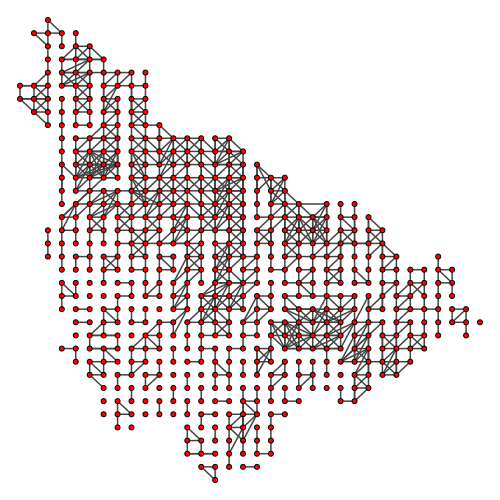

In [15]:
# Rede cujo limiar foi estabelecido para obter o mesmo número de arestas observado na rede GT-Network (Pearson)
g_graph_1270[0]

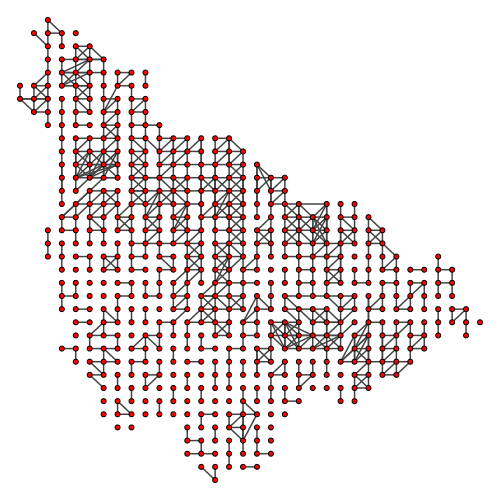

In [16]:
# Rede cujo limiar foi estabelecido de acordo com a relação entre o valor de MI e o diâmetro da rede
g_graph_max_diameter[0]

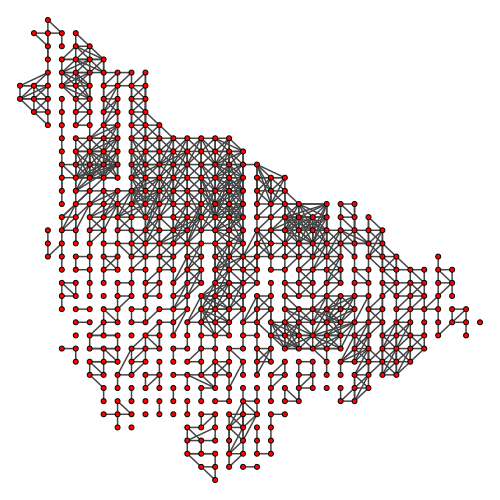

In [17]:
# Rede cujo limiar foi estabelecido através de 1% das maiores correlações
g_graph_highest_corr[0]

---
### Backbone para cada rede

In [18]:
i = time.time()
# Edges: 1270 
backbone_1270 = backbone(g_graph_full[1],0.1272)

# Edges: 964
backbone_max_diameter = backbone(g_graph_full[1],0.1124)

# Edges: 1720
backbone_highest_corr = backbone(g_graph_full[1],0.14254)
e = time.time()
print(e-i,'s')

3.5062990188598633 s


---
### Redes Backbone


In [19]:
# Desired number of edges: 1270 
g_graph_backbone_1270 = g_graph(backbone_1270)

# Desired number of edges: 964
g_graph_backbone_max_diameter = g_graph(backbone_max_diameter)

# Desired number of edges: 1720
g_graph_backbone_highest_corr = g_graph(backbone_highest_corr)

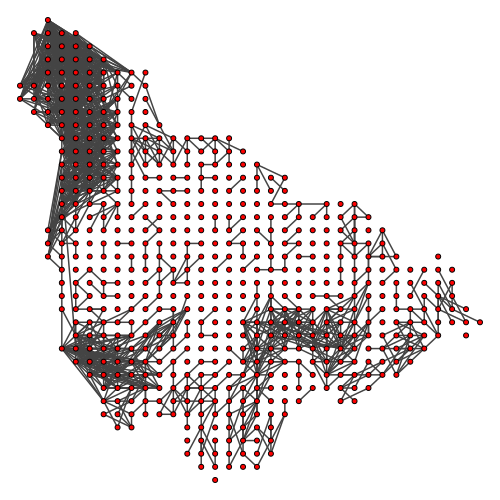

In [20]:
g_graph_backbone_1270[0]

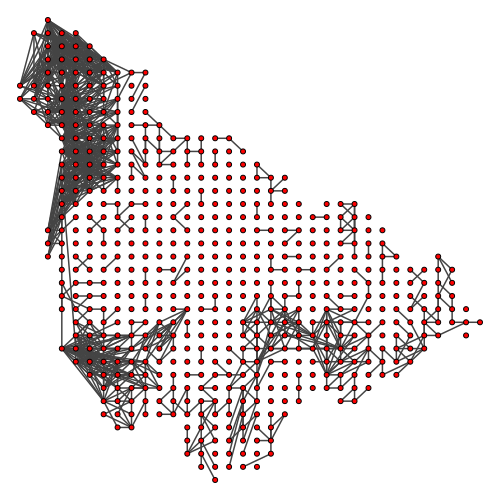

In [21]:
g_graph_backbone_max_diameter[0]

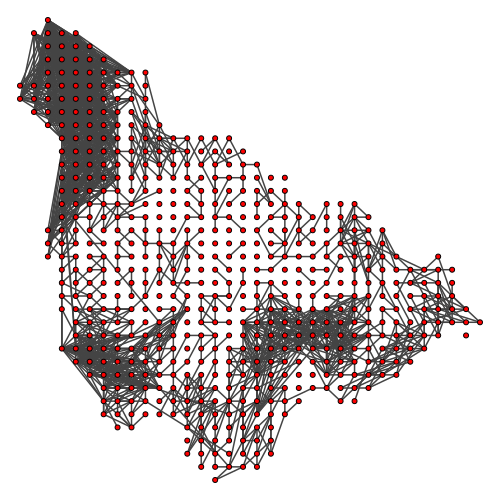

In [22]:
g_graph_backbone_highest_corr[0]

---
### Metrics
>Número de componentes, Média dos componentes, Número de singletons, Tamanho do maior componente, Average shortest path, Clustering coefficient, Diâmetro, Parâmetro de heterogeneidade para as distribuições de grau

In [24]:
# Global threshold based networks

# 1270 edges
metrics_graph_1270 = metrics(g_graph_1270[1]).all_metrics()

# threshold defined by the maximum diameter
metrics_graph_max_diameter = metrics(g_graph_max_diameter[1]).all_metrics()

# threshold defined by the highest correlation (1%)
metrics_graph_highest_corr = metrics(g_graph_highest_corr[1]).all_metrics()

# Backbone based networks

# Number of edges: 1270 
metrics_graph_backbone_1270 = metrics(g_graph_backbone_1270[1]).all_metrics()

# Number of edges: 964
metrics_graph_backbone_max_diameter = metrics(g_graph_backbone_max_diameter[1]).all_metrics()

# Number of edges: 1720
metrics_graph_backbone_highest_corr = metrics(g_graph_backbone_highest_corr[1]).all_metrics()

In [36]:
metrics_gt_df = pd.DataFrame([metrics_graph_1270[0],metrics_graph_1270[1]['n_comp'],metrics_graph_1270[1]['n_singletons'],metrics_graph_1270[1]['biggest_comp'],metrics_graph_1270[1]['avg_comp'],metrics_graph_1270[2],metrics_graph_1270[3],metrics_graph_1270[4]],index=['Heterogeneity Parameter','Number of components','Number of singletons','Biggest component','Average component','Avearge shortest path','Clustering coefficient','Diameter'],columns=['Global threshold for 1270 edges'])
metrics_gt_df['Global threshold for maximum diameter'] = [metrics_graph_max_diameter[0],metrics_graph_max_diameter[1]['n_comp'],metrics_graph_max_diameter[1]['n_singletons'],metrics_graph_max_diameter[1]['biggest_comp'],metrics_graph_max_diameter[1]['avg_comp'],metrics_graph_max_diameter[2],metrics_graph_max_diameter[3],metrics_graph_max_diameter[4]]
metrics_gt_df['Global threshold for the highest correlations'] = [metrics_graph_highest_corr[0],metrics_graph_highest_corr[1]['n_comp'],metrics_graph_highest_corr[1]['n_singletons'],metrics_graph_highest_corr[1]['biggest_comp'],metrics_graph_highest_corr[1]['avg_comp'],metrics_graph_highest_corr[2],metrics_graph_highest_corr[3],metrics_graph_highest_corr[4]]

In [37]:
metrics_gt_df

,Global threshold for 1270 edges,Global threshold for maximum diameter,Global threshold for the highest correlations
Heterogeneity Parameter,1.386432,1.422816,1.382081
Number of components,49.000000,82.000000,27.000000
Number of singletons,18.000000,33.000000,9.000000
Biggest component,430.000000,305.000000,479.000000
Average component,11.979592,7.158537,21.740741
Avearge shortest path,11.811405,10.381185,10.129646
Clustering coefficient,0.500394,0.474442,0.536811
Diameter,40.000000,49.000000,38.000000


In [38]:
metrics_bb_df = pd.DataFrame([metrics_graph_backbone_1270[0],metrics_graph_backbone_1270[1]['n_comp'],metrics_graph_backbone_1270[1]['n_singletons'],metrics_graph_backbone_1270[1]['biggest_comp'],metrics_graph_backbone_1270[1]['avg_comp'],metrics_graph_backbone_1270[2],metrics_graph_backbone_1270[3],metrics_graph_backbone_1270[4]],index=['Heterogeneity Parameter','Number of components','Number of singletons','Biggest component','Average component','Avearge shortest path','Clustering coefficient','Diameter'],columns=['Backbone for 1270 edges'])
metrics_bb_df['Backbone for maximum diameter'] = [metrics_graph_backbone_max_diameter[0],metrics_graph_backbone_max_diameter[1]['n_comp'],metrics_graph_backbone_max_diameter[1]['n_singletons'],metrics_graph_backbone_max_diameter[1]['biggest_comp'],metrics_graph_backbone_max_diameter[1]['avg_comp'],metrics_graph_backbone_max_diameter[2],metrics_graph_backbone_max_diameter[3],metrics_graph_backbone_max_diameter[4]]
metrics_bb_df['Backbone for the highest correlations'] = [metrics_graph_backbone_highest_corr[0],metrics_graph_backbone_highest_corr[1]['n_comp'],metrics_graph_backbone_highest_corr[1]['n_singletons'],metrics_graph_backbone_highest_corr[1]['biggest_comp'],metrics_graph_backbone_highest_corr[1]['avg_comp'],metrics_graph_backbone_highest_corr[2],metrics_graph_backbone_highest_corr[3],metrics_graph_backbone_highest_corr[4]]

In [39]:
metrics_bb_df

,Backbone for 1270 edges,Backbone for maximum diameter,Backbone for the highest correlations
Heterogeneity Parameter,2.572515,2.962490,2.138550
Number of components,124.000000,202.000000,52.000000
Number of singletons,96.000000,152.000000,42.000000
Biggest component,381.000000,152.000000,520.000000
Average component,4.733871,2.905941,11.288462
Avearge shortest path,9.771663,3.880094,8.452780
Clustering coefficient,0.163441,0.161835,0.171204
Diameter,41.000000,19.000000,34.000000


#### Relation between geographic distance and topological distance

In [53]:
# Execution time: 38s
i = time.time()
# GT-based networks

shortest_paths_gt_1270 = shortest_paths(g_graph_1270[1],weight=False)
shortest_paths_gt_max_diameter = shortest_paths(g_graph_max_diameter[1],weight=False)
shortest_paths_gt_highest_correlation = shortest_paths(g_graph_highest_corr[1],weight=False)

# BB-based networks

#shortest_paths_bb_1270 = shortest_paths(g_graph_backbone_1270[1],weight=False)
#shortest_paths_bb_max_diameter = shortest_paths(g_graph_backbone_max_diameter[1],weight=False)
#shortest_paths_bb_highest_correlation = shortest_paths(g_graph_backbone_highest_corr[1],weight=False)

e = time.time()
print(e-i,'s')

37.79857110977173 s


In [54]:
shortest_paths_gt_1270_geo_top = {}
shortest_paths_gt_max_diameter_geo_top = {}
shortest_paths_gt_highest_correlation_geo_top = {}
shortest_paths_bb_1270_geo_top = {}
shortest_paths_bb_max_diameter_geo_top = {}
shortest_paths_bb_highest_correlation_geo_top = {}

for i in shortest_paths_gt_1270:
    shortest_paths_gt_1270_geo_top[i] = [shortest_paths_gt_1270[i],geo_dist[i]]
    
for i in shortest_paths_gt_max_diameter:
    shortest_paths_gt_max_diameter_geo_top[i] = [shortest_paths_gt_max_diameter[i],geo_dist[i]]
    
for i in shortest_paths_gt_highest_correlation:
    shortest_paths_gt_highest_correlation_geo_top[i] = [shortest_paths_gt_highest_correlation[i],geo_dist[i]]

"""
for i in shortest_paths_bb_1270:
    shortest_paths_bb_1270_geo_top[i] = [shortest_paths_bb_1270[i],geo_dist[i]]
    
for i in shortest_paths_bb_max_diameter:
    shortest_paths_bb_max_diameter_geo_top[i] = [shortest_paths_bb_max_diameter[i],geo_dist[i]]
    
for i in shortest_paths_bb_highest_correlation:
    shortest_paths_bb_highest_correlation_geo_top[i] = [shortest_paths_bb_highest_correlation[i],geo_dist[i]]
"""

'\nfor i in shortest_paths_bb_1270:\n    shortest_paths_bb_1270_geo_top[i] = [shortest_paths_bb_1270[i],geo_dist[i]]\n    \nfor i in shortest_paths_bb_max_diameter:\n    shortest_paths_bb_max_diameter_geo_top[i] = [shortest_paths_bb_max_diameter[i],geo_dist[i]]\n    \nfor i in shortest_paths_bb_highest_correlation:\n    shortest_paths_bb_highest_correlation_geo_top[i] = [shortest_paths_bb_highest_correlation[i],geo_dist[i]]\n'

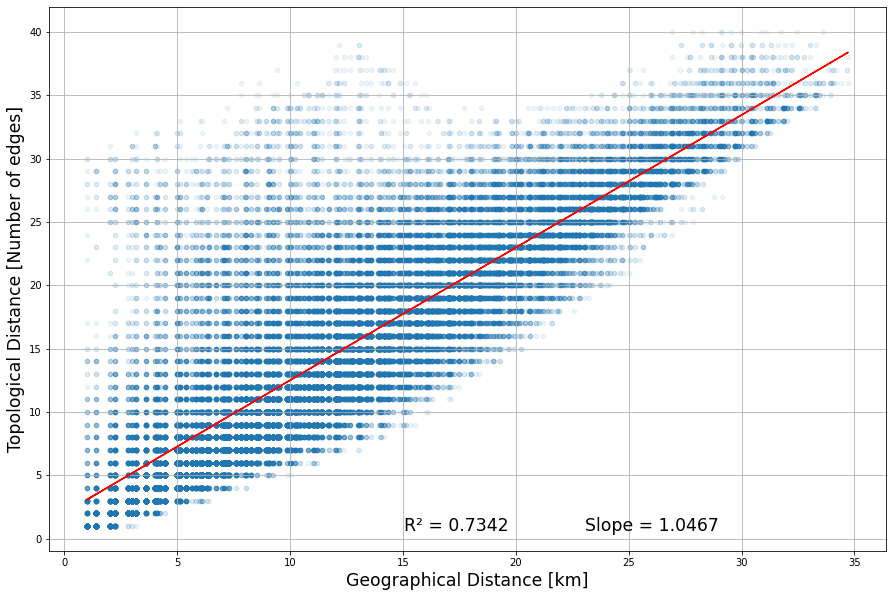

In [55]:
plot_geo_top(shortest_paths_gt_1270_geo_top)

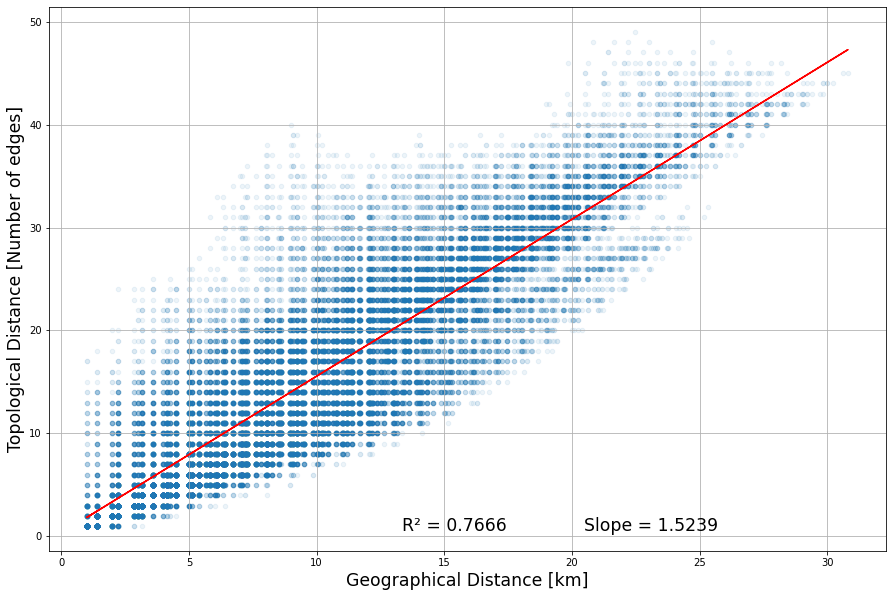

In [56]:
plot_geo_top(shortest_paths_gt_max_diameter_geo_top)

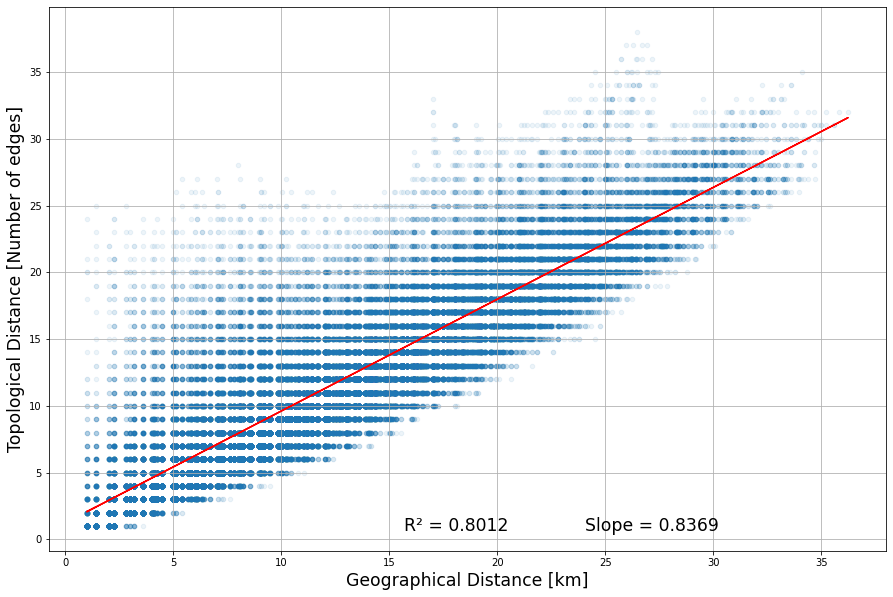

In [57]:
plot_geo_top(shortest_paths_gt_highest_correlation_geo_top)

In [127]:
p = {} # (pair): [geo, top]
c = 1
for i in range(g_graph_highest_corr[1].vcount()):
    for j in range(c,g_graph_highest_corr[1].vcount()):
        if not(g_graph_highest_corr[1].vs[i].degree() == 0 or g_graph_highest_corr[1].vs[j].degree() == 0):
            top_dist = g_graph_highest_corr[1].shortest_paths(source=g_graph_highest_corr[1].vs[i],target=g_graph_highest_corr[1].vs[j])[0][0]
            if not (top_dist == float('inf')):
                p[i,j] = [top_dist,geo_dist[i,j]]
    c+=1